# 2017-09-08 Quicklook to investigate BaSTi truncation #

wiclarks@umich.edu :  started 2017-09-08

**Purpose:** examine if BaSTi is truncating objects that lie outside its canonical isochrone metallicity range, and, if so, try to determine what the effects are and where along the process this truncation happens. Contents:
1. Summary and Results;
2. Setup
3. Method definitions;
4. Set parameters for analysis;
5. Run the analyses

# 1. Summary and results #

## 1.1. Results ##

From the broad-Gaussian star-formation histories (Sections 5.1 and 5.2 below):
* At both the metal-rich and metal-poor ends, BaSTi appears to be imposing a hard cut-off on the magnitudes and colors. See Sections 5.1 and 5.2;
* This does not seem to be a simple pile-up (where objects with [Fe/H] > some range just get assigned the limit). See middle-left panels of Sections 5.1 and 5.2; 
     * Are objects with metallicities outside the ranges being reflected at the border?

From the "test-patterns" (sections 5.3 and 5.4 below):
* If the *median* [Fe/H] is outside the range $-2.3 \lesssim [Fe/H] \lesssim +0.4$, the median metallicity of the population is altered to those limits (Section 5.3, upper-left panel);
* Applying a scatter in [Fe/H] causes BaSTi to assign [Fe/H] values that can exceed these limits (Section 5.4, upper-left panel);
* However, the colors and magnitudes still show hard limits at *both* ends of the metallicity distribution (5.4, lower-left panel).

## 1.2. Method ##

* Compare the requested [Fe/H] distribution (from the star formation history) with the simulated [Fe/H] from the _HRD.fits.gz file;
* Plot the (F606W-F814W, F606W) color-magnitude diagram (absolute magnitudes), visually inspect for abrupt edges;
* Select a region along the Main-Sequence for further study;
* Fit a "median" sequence of F606W against (F606W-F814W) to objects in this region, ensuring it lies well within either extreme in the color-magnitude distribution;
* Compute absolute magnitude offsets from the median;
* Plot the histogram to look for strong peaks near the edges.

**Files:** All the BaSTi outputs tested, as well as user inputs, can be found in the ../supporting/synthPops/ directory of this repository. Uncomment the following line to see them.

In [1]:
# ! ls ../supporting/synthPops

# 2. Setup #

In [2]:
# import a few needed things
import os
import numpy as np
from astropy.table import Table, Column

In [3]:
import matplotlib.pylab as plt
%matplotlib inline

In [4]:
plt.style.use('ggplot')

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [6]:
# set up path for all our figures
dirPlots = './plots'
if not os.access(dirPlots, os.R_OK):
    if len(dirPlots) > 2:
        os.mkdir(dirPlots)
    
# output files (if we want to examine the deltas in more detail)
dirOuts = './outputs'
if not os.access(dirOuts, os.R_OK):
    if len(dirOuts) > 2:
        os.mkdir(dirOuts)


In [7]:
# directory for synthetic populations and .sfh files
dirSupport = '../supporting/synthPops'

# 3. Define a few useful methods #

This is a quick-look analysis, refactored into methods so that it can be repeated for multiple simulations.

In [8]:
def readSFH(pathIn='BLAH'):
    
    """Reads the star formation history file"""
    
    if not os.access(pathIn, os.R_OK):
        return Table()
    
    tDum = Table.read(pathIn, format='ascii', data_start=1, comment='#')
    
    # assign the columns
    colNames = ['Age', 'Rate', 'meanFeH', 'sigmFeH']
    for iName in range(len(colNames)):
        tDum[tDum.colnames[iName]].name = colNames[iName]
        
    return tDum

In [9]:
def performSubselection(tPho=Table(), xLo=0.7, xHi=0.8, yLo=5.0, yHi=8.0, \
                       colMagBlu='F606Wacs', colMagRed='F814Wacs', colMagMag='F606Wacs'):
    
    """Return boolean selection indices for non-binaries and for polygon"""
    
    vMag = tPho[colMagMag]
    vCol = tPho[colMagBlu] - tPho[colMagRed]
    
    # not a binary?
    bBinaries = tPho['M2'] > 0
    
    # inside polygon?
    bPoly = (vCol >= xLo) & (vCol < xHi) & (vMag >= yLo) & (vMag < yHi)
    
    return vCol, vMag, bBinaries, bPoly
    

In [10]:
def findMedianSequence(vCol, vMag, bShow, bPoly, xLo=0.7, xHi=0.8, yLo=5.0, yHi=8.0, degFit=2, \
                       nMed=10, nMin=10, useMin=False):
    
    """Gets the median sequence for the population."""

    # We'll assume the booleans have been defined elsewhere
    
    # find the median sequence in our selection box. For this quicklook, we don't have to be too sophisticated here...
    vXlo = np.linspace(xLo, xHi, nMed, endpoint=False)
    vXhi = vXlo + (vXlo[1]-vXlo[0])

    # medians
    vXmed = vXlo * 0.
    vYmed = vXmed * 0.
    bGood = np.isfinite(vXmed)
    
    for iMed in range(np.size(vXlo)):
        bHere = (bShow) & (bPoly) & (vCol >= vXlo[iMed]) & (vCol < vXhi[iMed])
        
        if np.sum(bHere) < nMin:
            bGood[iMed] = False
            continue
        
        if not useMin:
            vXmed[iMed] = np.median(vCol[bHere])
            vYmed[iMed] = np.median(vMag[bHere])
        else:
            iMax = np.argmin(vMag[bHere])
            vXmed[iMed] = np.copy(vCol[bHere][iMax])
            vYmed[iMed] = np.copy(vMag[bHere][iMax])
            
    
    # trim by passed...
    vXmed = vXmed[bGood]
    vYmed = vYmed[bGood]
    
    # ... and fit the median sequence to this
    parsMed = np.polyfit(vXmed, vYmed, deg=degFit)
    
    return parsMed, vXmed, vYmed
    

In [11]:
# refactored our plotting into a method
def showSelectedData(tPop, bShow, xLo, xHi, yLo, yHi, \
                         vXmed, vYmed, parsMed, \
                    colorMin=0.4, colorMax=1.0, magMin=3., magMax=8., \
                    cmFeH='plasma', \
                    colMagBlu='F606Wacs', colMagRed='F814Wacs', colMagMag='F606Wacs', \
                    figNam='TEST', sTitle='', \
                    fehRange=np.array([]), \
                    tSFH=Table()):
    
    """Plot the metallicities commanded and the CMD resulting"""

    # plot the commanded metallicities
    fig1 = plt.figure(1, figsize=(12,5))
    fig1.clf()

    # what color-scheme shall we use?
    #cmFeH = 'jet'

    # CMD plot limits
    #colorMin = 0.3
    #colorMax = 1.5
    #magMin = 0.
    #magMax = 8.

    # duplicative for the moment...
    vMag = tPop[colMagMag]
    vCol = tPop[colMagBlu] - tPop[colMagRed]
    
    # Do the plots
    # convenience variables
    ax1 = fig1.add_subplot(1,2,1)
    dumFeH = ax1.scatter(tPop['ID'][bShow], tPop['FeH'][bShow], s=4, \
                         alpha=0.05, \
                         edgecolor='0.7', \
                         c='0.0', \
                        label='Simulated population')
    ax1.set_xlabel('ID')
    ax1.set_ylabel('[Fe/H]')

    # If the star formation history has been supplied, plot it...
    if len(tSFH) > 0:
        xRange = np.copy(ax1.get_xlim())
        for iSF in range(len(tSFH)):
            if tSFH[iSF]['Rate'] < 1e-3:
                continue
            yThis = np.copy(tSFH[iSF]['meanFeH'])
            thisLabel=''
            if iSF < 1:
                thisLabel='Specified mean SFH'
            dumPop = ax1.plot(xRange, [yThis, yThis], 'g-', label=thisLabel, alpha=0.3)
        ax1.set_xlim(xRange)
        
    leg1 = ax1.legend(loc=4, frameon=True)
    leg1.get_frame().set_facecolor('w')
    leg1.set_zorder(55)
        
    # customize the yrange?
    #if np.size(fehRange) == 2:
    #    ax1.set_ylim(fehRange + np.array([-0.2, 0.5]))
    
    ax2 = fig1.add_subplot(1,2,2)
    dumCMD = ax2.scatter(vCol[bShow], vMag[bShow], c=tPop['FeH'][bShow], \
                         s=9, alpha=1.0, edgecolor='None', cmap=cmFeH, \
                        zorder=2, label='')
    ax2.set_xlabel(r'$(%s - %s)_0$' % (colMagBlu, colMagRed))
    ax2.set_ylabel(r'$%s_0$' % (colMagMag))

    # hardwire some limits
    ax2.set_xlim(colorMin,colorMax)
    ax2.set_ylim(magMax, magMin)  # [sic]

    # show the selection polygon
    xPoly = np.array([xLo, xHi, xHi, xLo, xLo])
    yPoly = np.array([yLo, yLo, yHi, yHi, yLo])
    plt.plot(xPoly, yPoly, 'k--', zorder=15, label='')

    # overplot the median sequence
    xDum = np.linspace(xLo, xHi, 500)
    plt.plot(vXmed, vYmed, 'ko', zorder=5, ms=6, ls='-', label='Adopted fiducial')
    plt.plot(xDum, np.polyval(parsMed, xDum), 'k-', zorder=5)


    ax2.set_title(r'CMD color-coded by $[Fe/H]$')
    ax1.set_title(r'$[Fe/H]$, all simulated objects')
    
    cbar = fig1.colorbar(dumCMD, label=r'$[Fe/H]$')
    
    leg2 = ax2.legend(loc=3, frameon=True)
    leg2.get_frame().set_facecolor('w')
    leg2.set_zorder(55)
    
    fig1.subplots_adjust(hspace=0.40, wspace=0.45, top=0.85)
    

    
    # add a supertitle if given
    if len(sTitle) > 0:
        fig1.suptitle(sTitle, fontsize=14, y=0.95)
    
    if len(figNam) > 2:
        fig1.savefig(figNam)


In [12]:
# refactored our plotting cell into a method...
def showDeltas(difSel, fehSel, colSel, idSel, nBins=50, \
               cmapVsFeh='RdBu_r', cmapVsCol='plasma', \
              colMagBlu='F606Wacs', colMagRed='F814Wacs', \
              colMagMag='F606Wacs', figNam='TEST', \
              sTitle='', histAsFlux=False):

    
    """Show the deltas cut various ways"""
    
    # OK now show the residuals from the median as a function of color and metallicity...
    fig2 = plt.figure(2, figsize=(12,8))
    fig2.clf()

    ax21 = fig2.add_subplot(2,2,2)
    ax22 = fig2.add_subplot(2,2,1, sharex=ax21)
    if not histAsFlux:
        ax23 = fig2.add_subplot(2,2,3, sharex=ax21)
    else:
        ax23 = fig2.add_subplot(2,2,3)
    ax24 = fig2.add_subplot(2,2,4)

    # for convenience labeling
    sLabelDelta = r'$\Delta %s_0$' % (colMagMag)
    sLabelColor = r'$(%s - %s)_0$' % (colMagBlu, colMagRed)
    sLabelFeh = r'$[Fe/H]_0$'

    sLabelDeltaSho = sLabelDelta[:]
    if histAsFlux:
        sLabelDeltaSho = r'$2.512^{\Delta %s}$' % (colMagMag)
    
    # scatter - delta vs commanded [Fe/H]
    dumResFeH = ax21.scatter(difSel, fehSel, c=colSel, cmap=cmapVsFeh, \
                             alpha=0.6, edgecolor='None', s=9)
    ax21.set_ylabel(sLabelFeh)
    ax21.set_xlabel(sLabelDelta)


    axins21 = inset_axes(ax21,
               width="5%", # width = 10% of parent_bbox width
               height="100%", # height : 50%
               loc=6,
               bbox_to_anchor=(1.00, 0., 1, 1),
               bbox_transform=ax21.transAxes,
               borderpad=0)
    cbar21 = fig2.colorbar(dumResFeH, cax=axins21, label=sLabelColor)
    #cbar21.set_label(sLabelColor, rotation=270)
    
    ax21.set_title(r'%s vs %s' % (sLabelFeh, sLabelDelta))

    # scatter - delta vs color
    dumResCol = ax22.scatter(difSel, colSel, c=fehSel, cmap=cmapVsCol, \
                            alpha=0.5, edgecolor='None', s=9)
    ax22.set_ylabel(sLabelColor)
    ax22.set_xlabel(sLabelDelta)

    axins22 = inset_axes(ax22,
               width="5%", # width = 10% of parent_bbox width
               height="100%", # height : 50%
               loc=6,
               bbox_to_anchor=(1.00, 0., 1, 1),
               bbox_transform=ax22.transAxes,
               borderpad=0)
    cbar22 = fig2.colorbar(dumResCol, cax=axins22, label=sLabelFeh)
    #cbar22.set_label(sLabelFeh, rotation=0)
    
    ax22.set_title(r'%s vs %s' % (sLabelColor, sLabelDelta))
    

    
    # histogram of deltas
    # try this as a flux ratio
    rangeMag = [np.min(difSel)-0.1, np.max(difSel)+0.1]
    rangeFlux = 2.512**np.array(rangeMag)
    
    valusHist = np.copy(difSel)
    rangeHist = np.copy(rangeMag)
    if histAsFlux:
        valusHist = 2.512**difSel
        rangeHist = np.copy(rangeFlux)
    
    dumHist = ax23.hist(valusHist, bins=nBins, \
                        #range=[-0.2,0.5], \
                        range=rangeHist, \
                        orientation='vertical', \
                       color='0.1', alpha=0.7, zorder=5)
    ax23.set_xlabel(sLabelDeltaSho)
    #if histAsFlux:
    #    ax23.set_xlabel(r'2.512$^{\Delta %s}$' % (colMagMag))
    ax23.set_ylabel(r'N(%s)' % (sLabelDelta))

    ax23.set_title(r'%s histogram' % (sLabelDeltaSho))
    if histAsFlux:
        ax23.set_title(r'Flux ratio histogram')
        
    
    # like our first plot, this time only the polygon-selected objects
    dumIDs = ax24.scatter(idSel, fehSel, c=difSel, cmap='viridis', \
                         alpha=0.7, edgecolor='None', s=9)
    ax24.set_xlabel('ID')
    ax24.set_ylabel(sLabelFeh)

    axins24 = inset_axes(ax24,
               width="5%", # width = 10% of parent_bbox width
               height="100%", # height : 50%
               loc=6,
               bbox_to_anchor=(1.00, 0., 1, 1),
               bbox_transform=ax24.transAxes,
               borderpad=0)

    cbar24 = fig2.colorbar(dumIDs, cax=axins24, label=sLabelDelta)
    #cbar24.set_label(sLabelDelta, rotation=270)
    
    ax24.set_title(r'%s vs ID' % (sLabelFeh))
    
    fig2.subplots_adjust(hspace=0.40, wspace=0.45, top=0.85)
    
    # add a supertitle if given
    if len(sTitle) > 0:
        fig2.suptitle(sTitle, fontsize=14, y=0.95)
    
    if len(figNam) > 2:
        fig2.savefig(figNam)

In [13]:
# wrapper for our analysis
def wrapCheckBasti(stemPop = 'metRich_fewBinaries_ss_eta0p4_', \
                   degFit=3, nMed=15, nMin=10, \
                   xLo=0.7, xHi=0.9, yLo=5.0, yHi=7.5, \
                    colMagBlu='F606Wacs', colMagRed='F814Wacs', \
                   figStem='TEST', sTitle='', \
                  stripes=False, bothFigs=True, nBins=50, \
                  pathOut='', formatOut='fits', cmFeh='plasma', \
                  histAsFlux=False, \
                   doFigures=True):
    
    """Wrapper for the delta-mag check"""
    
    pathSFH = '%s/%s.sfh' % (dirSupport, stemPop)
    pathPOP = '%s/%s_hrd.fits.gz' % (dirSupport, stemPop)
    
    for thisPath in [pathSFH, pathPOP]:
        if not os.access(thisPath, os.R_OK):
            print "wrapCheckBasti WARN - cannot read input path %s" % (thisPath)
            return
        
    # load the population and its sfh
    tPop = Table.read(pathPOP, format='fits')
    try:
        tSfh = readSFH(pathSFH)
    
        tSfh['Age'] /= 1.0e9
        tSfh['Age'].format = '%.1f'
        tSfh['Age'].name = 'Age (Gy)'
    
        tSfh.pprint()
    except:
        print "WARN - problem loading SFH"
        tSfh = Table()
    
    colMagBlu = 'F606Wacs'
    colMagRed = 'F814Wacs'
    colMagMag = colMagBlu[:]

    # make the convenience-variables
    vCol, vMag, bBinaries, bPoly = performSubselection(tPop, xLo, xHi, yLo, yHi, \
                                                       colMagBlu, colMagRed, colMagMag)
    
    # anticipating other selections, let's set up a boolean now for only the objects we want to show...
    bShow = np.copy(~bBinaries)

    # now find the median sequence. Don't go for the exact minimum
    bFit = np.copy(bShow)
    if stripes:
        bMet = tPop['ID'] < 170000 #30000
        bFit = (bMet) & (bShow)
    
    parsMed, vXmed, vYmed = findMedianSequence(vCol, vMag, bFit, \
                                               bPoly, \
                                               xLo, xHi, yLo, yHi, \
                                               degFit, nMed, nMin, \
                                              useMin=stripes)
    
    #print np.sum(bShow)
    # What we'll actually use for the deltas later on...
    bSel = (bShow) & (bPoly)
    colSel = vCol[bSel]
    magSel = vMag[bSel]
    difSel = vMag[bSel] - np.polyval(parsMed, colSel)
    fehSel = tPop['FeH'][bSel]
    idSel = tPop['ID'][bSel]
            
    # write the deltas to disk if asked
    if len(pathOut) > 2:
        tDeltas = Table()
        tDeltas['idSel'] = Column(idSel, dtype=int)
        tDeltas['deltaMag'] = Column(difSel, unit='mag')
        tDeltas['magSel'] = Column(magSel, unit='mag')
        tDeltas['colSel'] = Column(colSel, unit='mag')
        tDeltas['fehSel'] = Column(fehSel, unit='dex')

        # add a bit of metadata. The "str()" is to deal with some weirdness
        # in the way metadata sometimes gets handled.
        tDeltas.meta['colMagBlu'] = str(colMagBlu)
        tDeltas.meta['colMagRed'] = str(colMagRed)
        tDeltas.meta['colMagMag'] = str(colMagMag)
        tDeltas.meta['pathSFH'] = str(pathSFH)
        tDeltas.meta['pathPOP'] = str(pathPOP)
        tDeltas.meta['degFit'] = int(degFit)
        tDeltas.meta['nMed'] = int(nMed)
        tDeltas.meta['nMin'] = int(nMin)
        tDeltas.meta['xLo'] = np.copy(xLo)
        tDeltas.meta['xHi'] = np.copy(xHi)
        tDeltas.meta['yLo'] = np.copy(yLo)
        tDeltas.meta['yHi'] = np.copy(yHi)
        tDeltas.meta['nBins'] = int(nBins)
        tDeltas.meta['stripes'] = stripes
        
        # now write this to disk
        tDeltas.write(pathOut, overwrite=True, format=formatOut)

        print "wrapCheckBasti INFO -- output deltas written to %s" % (pathOut)
        
    # and make the figures. Include figure names
    figNamSelect = '%s_select.png' % (figStem)
    figNamDeltas = '%s_deltas.png' % (figStem)
    
    # customize the y-range?
    yStripes = np.array([])
    if stripes:
        yStripes = np.array([np.min(tSfh['meanFeH']), np.max(tSfh['meanFeH'] )])
    
    if not doFigures:
        return
    
    showSelectedData(tPop, bShow, xLo, xHi, yLo, yHi, vXmed, vYmed, parsMed, \
                    colMagBlu=colMagBlu, colMagRed=colMagRed, colMagMag=colMagMag, \
                    figNam=figNamSelect, sTitle=sTitle, fehRange=yStripes, \
                    tSFH=tSfh, cmFeH=cmFeh)
    
    if bothFigs:
        showDeltas(difSel, fehSel, colSel, idSel, figNam=figNamDeltas, sTitle=sTitle, \
                   nBins=nBins, cmapVsCol=cmFeh, histAsFlux=histAsFlux)

# 4.  Set some common parameters for the analyses #

In [14]:
# set up a selection region in the CMD to estimate a "main sequence"
xLo = 0.65
xHi = 0.75
yLo = 5.0
yHi = 7.5

# bins for histogram
nBins=100

# control variables for the fit
degFit=3
nMed=15
nMin=10

# 5. Run the quick-look analyses #

The methods produce figures with the following panels:
* Upper-left panel: requested [Fe/H] from the SFH (green lines); [Fe/H] reported in the simulation (gray points);
* Upper-right panel: the (F606W-F814W, F606W) CMDs, color-coded by [Fe/H] and with the adopted fiducial sequence overplotted.
* Middle-left: color vs magnitude residual from fiducial, color-coded by [Fe/H];
* Middle-right: [Fe/H] vs magnitude residual, color-coded by color;
* Lower-left: histogram of the magnitude residuals;
* Lower-right: [Fe/H] vs row number, color-coded by magnitude residual.

The analyses were run on the following BaSTi synthetic stellar populations with user-specified SFHs:
* 5.1. Metal-rich (scaled-to-solar): [Fe/H] = +0.24 +/- 0.19
* 5.2. Metal-poor Halo component (alpha-enhanced): [Fe/H] = -2.33 +/- 0.30
* 5.3. "Test-pattern:" Scaled-to-solar, [Fe/H] = -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, +0,4, +0.5, all +/- 0.0001 dex
* 5.4. "Test-pattern:" Scaled-to-solar, [Fe/H] = -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, +0,4, +0.5, all +/- 0.1 dex
* 5.5. The "Bulge" star formation history within BaSTI
     * (Note that this doesn't have [Fe/H] < -2.3, and only a little with [Fe/H] > +0.4).
* 5.6. Three-component $\alpha$-enhanced, medians near each limit and near the middle, all with 0.1 dex dispersion

## 5.1.  Metal-rich, scaled-to-solar: [Fe/H] = +0.24 +/- 0.19 ##

In [15]:
stemPop = 'FeH_p0p24_ss/Synth_Pop__Jul_17_23.57.48_CEST_2017_'
sName='testMetRich'
sTitl='metal-rich, scaled-to-solar, eta=0.4'

sStem='%s/%s' % (dirPlots, sName)
sDelt='%s/%s_deltas.fits' % (dirOuts, sName)

Age (Gy) Rate meanFeH sigmFeH
-------- ---- ------- -------
     8.0  1.0    0.24    0.19
     8.0  0.0    0.24    0.19
wrapCheckBasti INFO -- output deltas written to ./outputs/testMetRich_deltas.fits


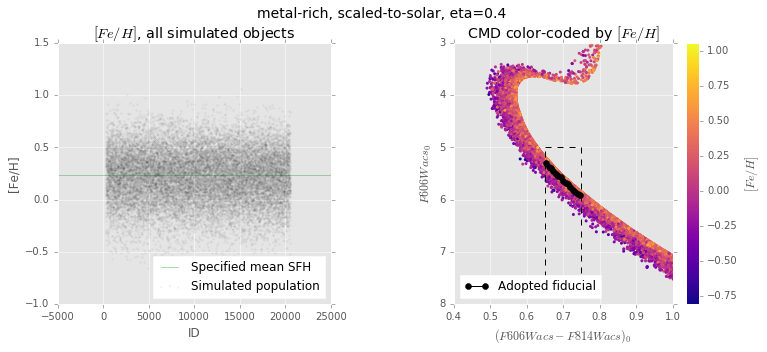

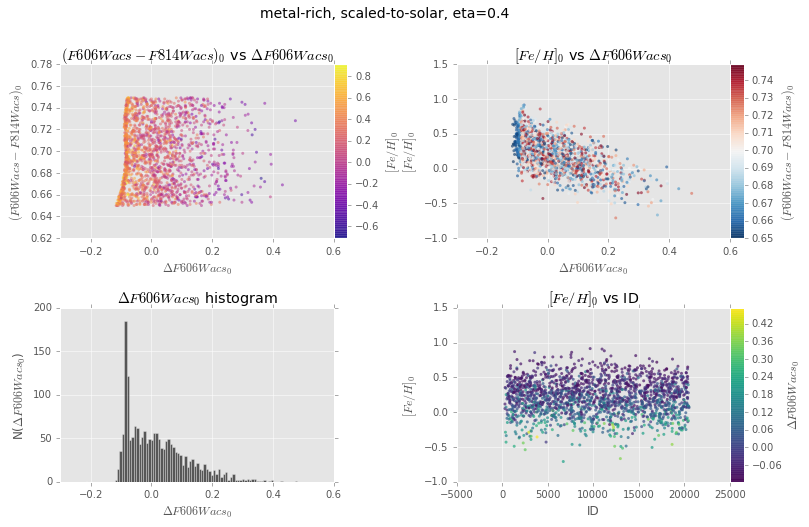

In [16]:
# let's try our wrapper
wrapCheckBasti(stemPop, degFit, nMed, nMin, xLo, xHi, yLo, yHi, figStem=sStem, \
               sTitle=sTitl, nBins=nBins, \
               bothFigs=True, pathOut=sDelt)

## 5.2.  Metal-poor, alpha-enhanced: [Fe/H] = -2.33 +/- 0.30 ##

In [17]:
stemPopHalo = 'FeH_m2p33_al/Synth_Pop__Aug_29_00.53.21_CEST_2017_'
sNameHalo='haloMetalPoor'
sTitlHalo='Metal-poor Alpha-enhanced: [Fe/H] = -2.33 +/- 0.3 dex'

sStemHalo='%s/%s' % (dirPlots, sNameHalo)
sDeltHalo='%s/%s_deltas.fits' % (dirOuts, sNameHalo)

Age (Gy) Rate meanFeH sigmFeH
-------- ---- ------- -------
    13.0  1.0   -2.33     0.3
    13.0  0.0   -2.33     0.3
wrapCheckBasti INFO -- output deltas written to ./outputs/haloMetalPoor_deltas.fits


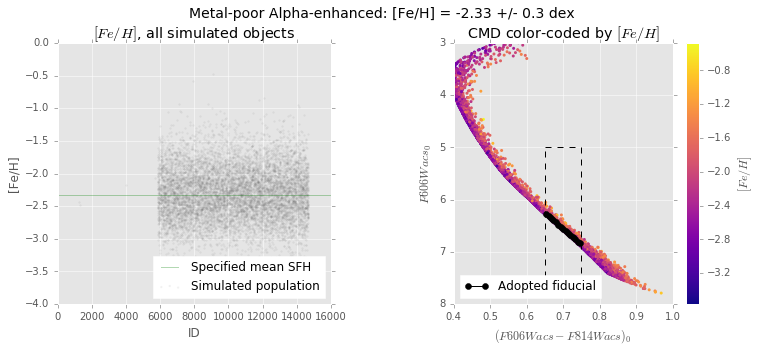

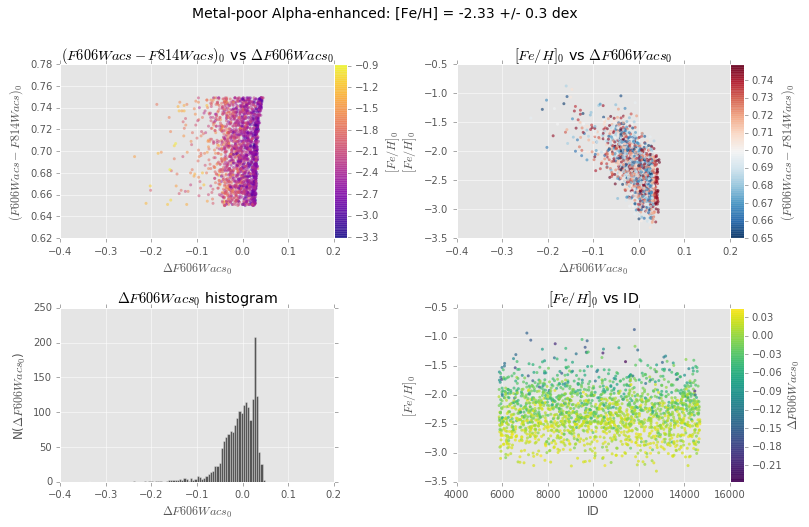

In [18]:
wrapCheckBasti(stemPopHalo, degFit, nMed, nMin, xLo, xHi, yLo, yHi, figStem=sStemHalo, nBins=nBins, \
               sTitle=sTitlHalo, \
               stripes=False, bothFigs=True, pathOut=sDeltHalo)

## 5.3.  "Test-pattern:" Scaled-to-solar, [Fe/H] = -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, +0,4, +0.5, all +/- 0.0001 dex ##

In [19]:
stemPop2 = 'testPattern_s0p001_ss/Synth_Pop__Sep_7_22.54.18_CEST_2017_'
sName2='testPatternSmallDispersion'
sTitl2='[Fe/H] = -3.0, -2.5... +0.4, +0.5, all +/- 0.0001 dex'

sStem2='%s/%s' % (dirPlots, sName2)
sDelt2='%s/%s_deltas.fits' % (dirOuts, sName2)

Age (Gy) Rate meanFeH sigmFeH
-------- ---- ------- -------
     7.0  0.1    -3.0     0.0
     7.0  0.0    -3.0     0.0
     7.0  0.1    -2.5     0.0
     7.0  0.0    -2.5     0.0
     7.0  0.1    -2.0     0.0
     7.0  0.0    -2.0     0.0
     7.0  0.1    -1.5     0.0
     7.0  0.0    -1.5     0.0
     7.0  0.1    -1.0     0.0
     7.0  0.0    -1.0     0.0
     7.0  0.1    -0.5     0.0
     7.0  0.0    -0.5     0.0
     7.0  0.1     0.0     0.0
     7.0  0.0     0.0     0.0
     7.0  0.1     0.4     0.0
     7.0  0.0     0.4     0.0
     7.0  0.1     0.5     0.0
     7.0  0.0     0.5     0.0
wrapCheckBasti INFO -- output deltas written to ./outputs/testPatternSmallDispersion_deltas.fits


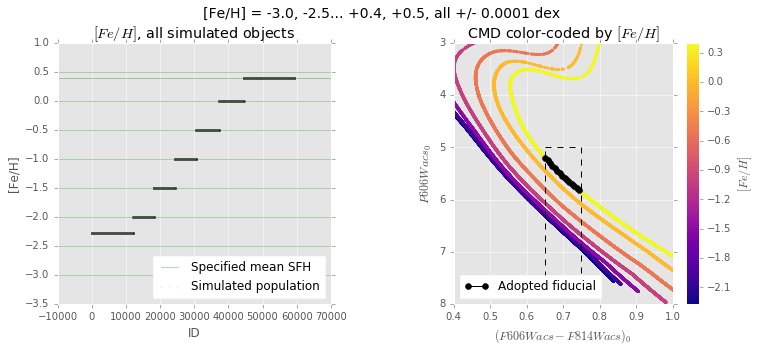

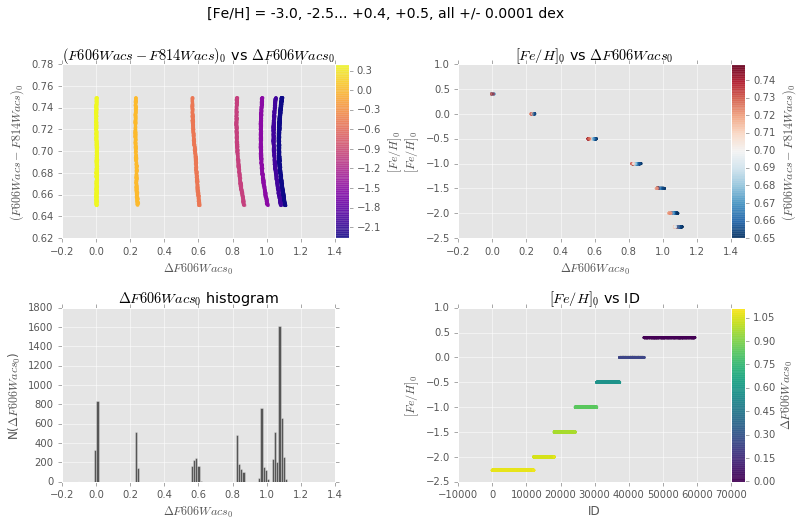

In [20]:
wrapCheckBasti(stemPop2, degFit, nMed, nMin, xLo, xHi, yLo, yHi, figStem=sStem2, nBins=nBins, \
               sTitle=sTitl2, stripes=True, \
              bothFigs=True, pathOut=sDelt2)

## 5.4.  "Test-pattern:" Scaled-to-solar, [Fe/H] = -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, +0,4, +0.5, all +/- 0.1 dex ##

In [21]:
stemPop3 = 'testPattern_s0p1_ss/Synth_Pop__Sep_8_14.54.22_CEST_2017_'
sName3='testPatternMedDispersion'
sTitl3='[Fe/H] = -3.0, -2.5... +0.4, +0.5, all +/- 0.1 dex'

sStem3='%s/%s' % (dirPlots, sName3)
sDelt3='%s/%s_deltas.fits' % (dirOuts, sName3)


Age (Gy) Rate meanFeH sigmFeH
-------- ---- ------- -------
     7.0  0.1    -3.0     0.1
     7.0  0.0    -3.0     0.1
     7.0  0.1    -2.5     0.1
     7.0  0.0    -2.5     0.1
     7.0  0.1    -2.0     0.1
     7.0  0.0    -2.0     0.1
     7.0  0.1    -1.5     0.1
     7.0  0.0    -1.5     0.1
     7.0  0.1    -1.0     0.1
     7.0  0.0    -1.0     0.1
     7.0  0.1    -0.5     0.1
     7.0  0.0    -0.5     0.1
     7.0  0.1     0.0     0.1
     7.0  0.0     0.0     0.1
     7.0  0.1     0.4     0.1
     7.0  0.0     0.4     0.1
     7.0  0.1     0.5     0.1
     7.0  0.0     0.5     0.1
wrapCheckBasti INFO -- output deltas written to ./outputs/testPatternMedDispersion_deltas.fits


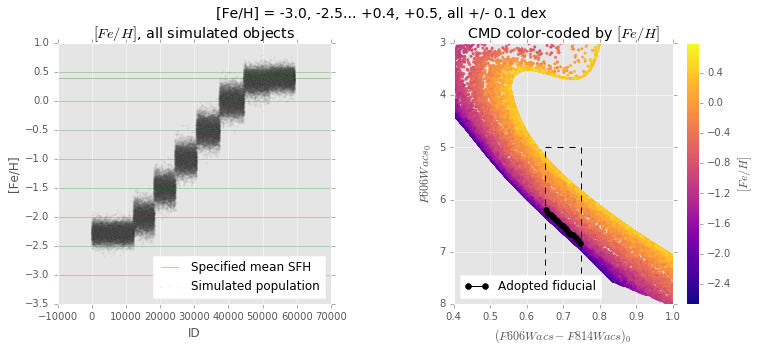

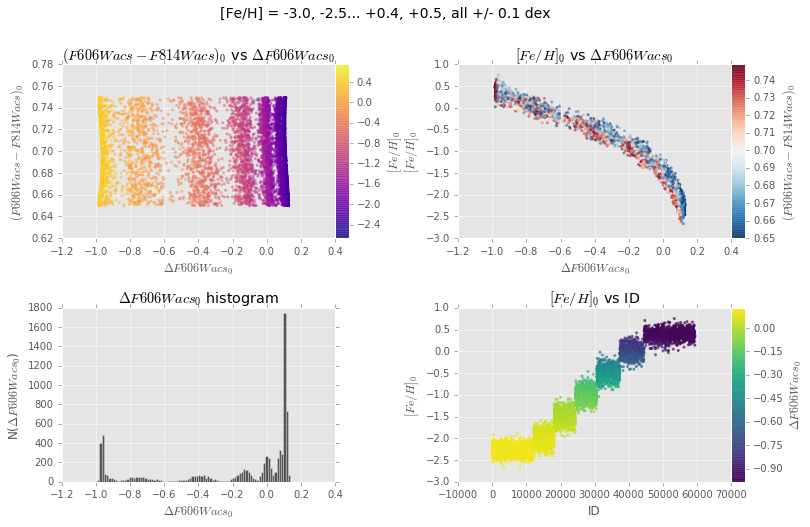

In [22]:
wrapCheckBasti(stemPop3, degFit, nMed, nMin, xLo, xHi, yLo, yHi, nBins=nBins, \
               figStem=sStem3, sTitle=sTitl3, stripes=False, \
              bothFigs=True, pathOut=sDelt3)

## 5.5. The "Bulge" star formation history in BaSTi, with Scaled-to-Solar isochrones ##

In [23]:
stemPopB = './bulgeBasti_ss/Synth_Pop__Sep_1_03.19.24_CEST_2017_'
sNameB='bulgeBasti_ss'
sTitlB='Bulge star formation history from BaSTi, Scaled-to-Solar'

sStemB='%s/%s' % (dirPlots, sNameB)
sDeltB='%s/%s_deltas.fits' % (dirOuts, sNameB)

Age (Gy) Rate meanFeH sigmFeH
-------- ---- ------- -------
     5.0 0.03    0.28     0.1
     7.0 0.06    0.21     0.1
     8.0 0.09    0.16     0.1
     9.0 0.17     0.1     0.1
     9.5 0.23    0.02     0.1
    10.0 0.32   -0.05     0.1
    10.5  0.5    -0.2     0.1
    11.0 0.73   -0.58     0.1
    11.5 0.93    -1.0     0.1
    12.0  0.0    -3.0     0.1
wrapCheckBasti INFO -- output deltas written to ./outputs/bulgeBasti_ss_deltas.fits


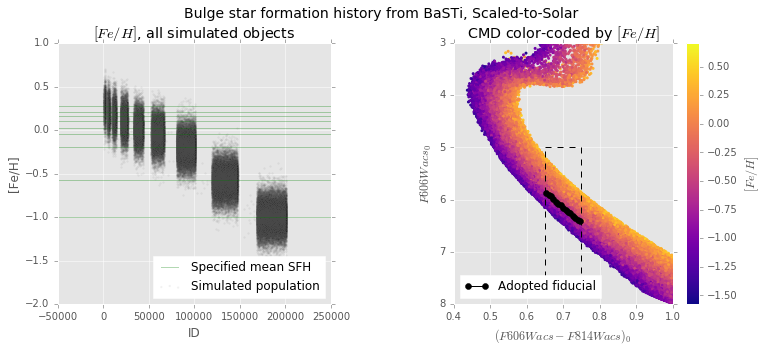

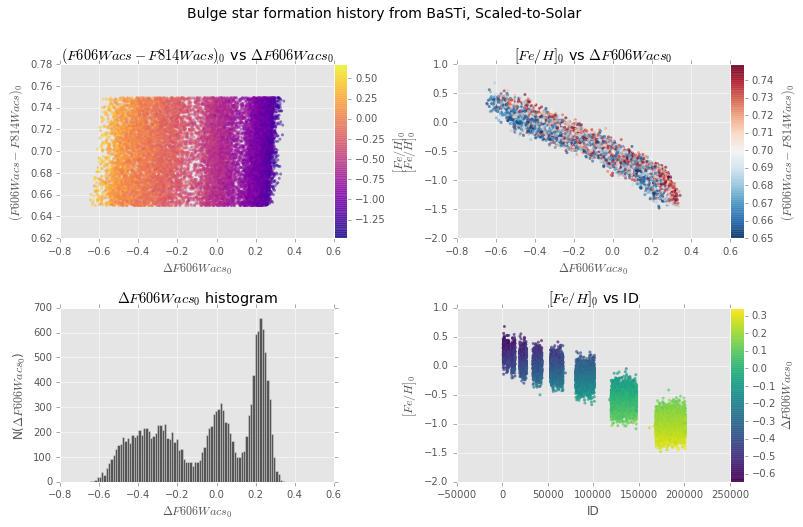

In [24]:
wrapCheckBasti(stemPopB, degFit, nMed, nMin, xLo, xHi, yLo, yHi, \
               figStem=sStemB, sTitle=sTitlB, nBins=nBins, \
               bothFigs=True, pathOut=sDeltB)

## 5.6.  Test-pattern, two components near the limits, one near the middle, $\alpha$-enhanced ##

In [25]:
stemPopTest = 'testPattern_3comp_al/Synth_Pop__Sep_9_19.48.56_CEST_2017_'
sNameTest='test3Comp'
sTitlTest='Test-pattern, two components near the limits, alpha-enhanced, eta=0.2'

sStemTest='%s/%s' % (dirPlots, sNameTest)
sDeltTest='%s/%s_deltas.fits' % (dirOuts, sNameTest)

Age (Gy) Rate meanFeH sigmFeH
-------- ---- ------- -------
     8.0 0.33    -2.5     0.1
     8.0  0.0    -2.5     0.1
     8.0 0.33    -1.2     0.1
     8.0  0.0    -1.2     0.1
     8.0 0.33    0.05     0.1
     8.0  0.0    0.05     0.1
wrapCheckBasti INFO -- output deltas written to ./outputs/test3Comp_deltas.fits


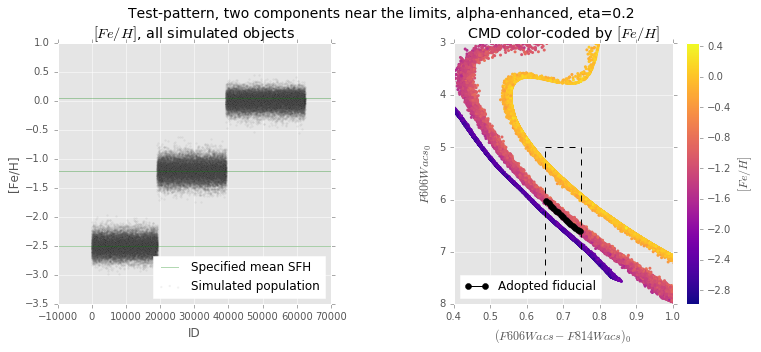

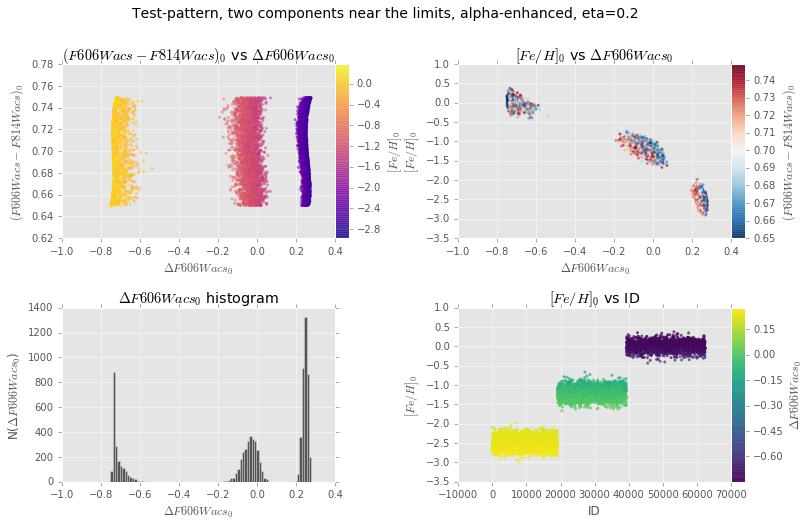

In [26]:
wrapCheckBasti(stemPopTest, degFit, nMed, nMin, xLo, xHi, yLo, yHi, \
               figStem=sStemTest, sTitle=sTitlTest, nBins=nBins, \
               bothFigs=True, pathOut=sDeltTest, stripes=False)

## 5.7 Metal-poor, $\alpha$-enhanced ##

For testing our mitigation strategies...

In [27]:
stemPopMP = 'FeH_m0p42_al/Synth_Pop__Sep_2_02.53.54_CEST_2017_'
sNameMP='testMetalPoor_m0p42'
sTitlMP='Metal-poor, alpha=enhanced, within limits'

sStemMP='%s/%s' % (dirPlots, sNameMP)
sDeltMP='%s/%s_deltas.fits' % (dirOuts, sNameMP)

Age (Gy) Rate meanFeH sigmFeH
-------- ---- ------- -------
     8.0 0.25   -0.42    0.24
     8.0  0.0   -0.42    0.24
     9.0 0.25   -0.42    0.24
     9.0  0.0   -0.42    0.24
    10.0 0.25   -0.42    0.24
    10.0  0.0   -0.42    0.24
    11.0 0.25   -0.42    0.24
    11.0  0.0   -0.42    0.24
wrapCheckBasti INFO -- output deltas written to ./outputs/testMetalPoor_m0p42_deltas.fits


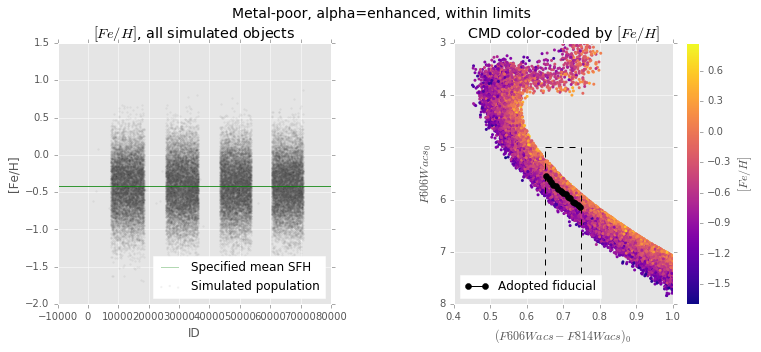

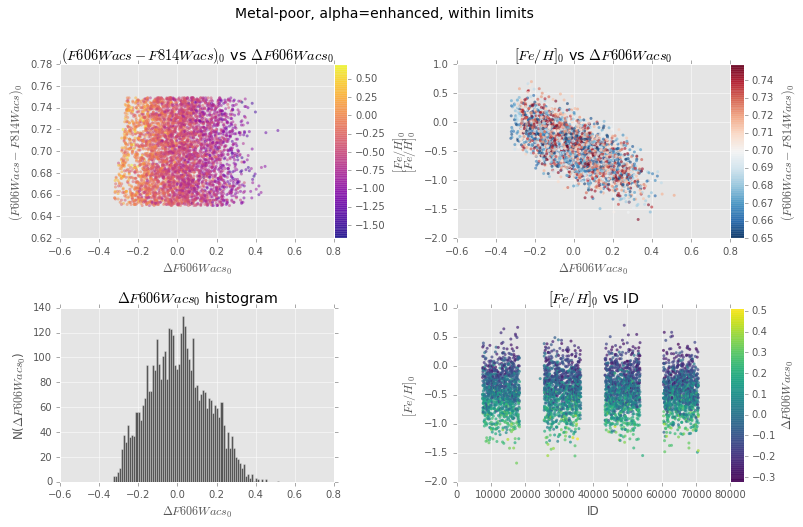

In [28]:
wrapCheckBasti(stemPopMP, degFit, nMed, nMin, xLo, xHi, yLo, yHi, \
               figStem=sStemMP, sTitle=sTitlMP, nBins=nBins, \
               bothFigs=True, pathOut=sDeltMP, stripes=False)

## 5.8 Metal-poor, $\alpha$-enhanced, all should be within boundaries ##

In [29]:
stemPopMP2 = 'FeH_m0p77_al/Synth_Pop__Sep_8_03.54.53_CEST_2017_'
sNameMP2='testMetalPoor_m0p77'
sTitlMP2='Metal-poor, alpha-enhanced, <[Fe/H]> =  -0.77'

sStemMP2='%s/%s' % (dirPlots, sNameMP2)
sDeltMP2='%s/%s_deltas.fits' % (dirOuts, sNameMP2)

Age (Gy) Rate meanFeH sigmFeH
-------- ---- ------- -------
     9.0  0.3   -0.77    0.24
     9.0  0.0   -0.77    0.24
    10.0  0.3   -0.77    0.24
    10.0  0.0   -0.77    0.24
    11.0  0.3   -0.77    0.24
    11.0  0.0   -0.77    0.24
wrapCheckBasti INFO -- output deltas written to ./outputs/testMetalPoor_m0p77_deltas.fits


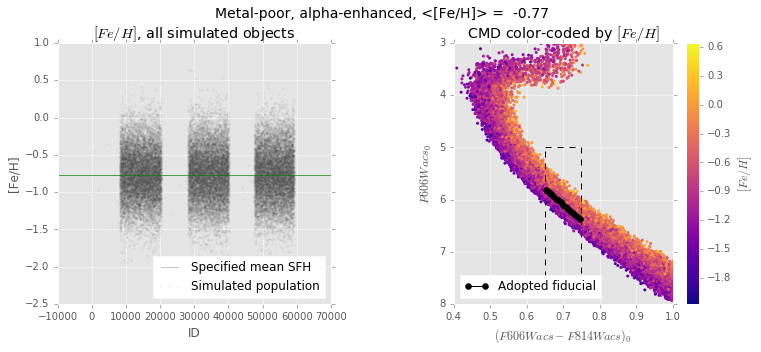

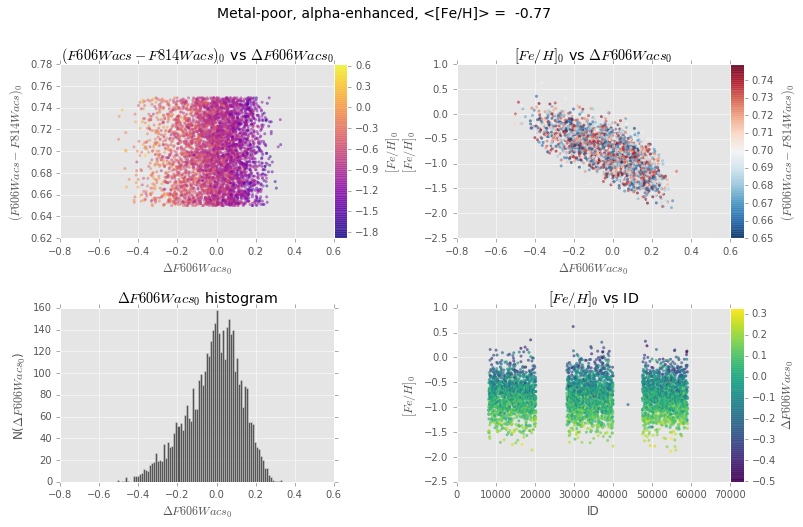

In [30]:
wrapCheckBasti(stemPopMP2, degFit, nMed, nMin, xLo, xHi, yLo, yHi, \
               figStem=sStemMP2, sTitle=sTitlMP2, nBins=nBins, \
               bothFigs=True, pathOut=sDeltMP2, stripes=False)

# A. Misc checking operations #

In [31]:
tDum = Table.read('./outputs/testMetRich_deltas.fits')

In [32]:
tDum.colnames

['idSel', 'deltaMag', 'magSel', 'colSel', 'fehSel']

In [33]:
tDum.meta

OrderedDict([('colMagBlu', 'F606Wacs'),
             ('colMagRed', 'F814Wacs'),
             ('colMagMag', 'F606Wacs'),
             ('PATHSFH',
              '../supporting/synthPops/FeH_p0p24_ss/Synth_Pop__Jul_17_23.57.48_CEST_2017_.sfh'),
             ('PATHPOP',
              '../supporting/synthPops/FeH_p0p24_ss/Synth_Pop__Jul_17_23.57.48_CEST_2017__hrd.fits.gz'),
             ('DEGFIT', 3),
             ('NMED', 15),
             ('NMIN', 10),
             ('NBINS', 100),
             ('STRIPES', False)])